<a href="https://colab.research.google.com/github/arjunjanamatti/sam_kirk_project/blob/master/ARIMA_live_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing packages and import libraries

In [1]:
!pip install ondemand
!pip install pmdarima

#### import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
#for deep learning model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima

### API key

In [3]:
#@markdown Enter your OnDemand API Key

your_api_key = 'f763078df987c8adec5bed096ecdcad0'  #@param {type: "string"}

import ondemand

od = ondemand.OnDemandClient(api_key=your_api_key)


Barchart OnDemand Client: https://ondemand.websol.barchart.com/


### Parameters to be set for symbol and minutes/days

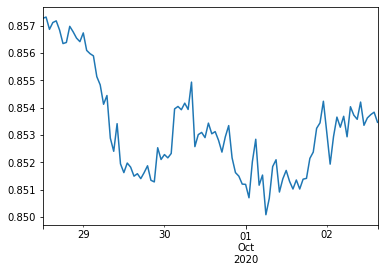

In [4]:
symbol = '^USDEUR'  #@param {type: "string"}

resp = od.history(symbol, 'minutes', interval=60, maxRecords=1440)['results']

prices = [bar['close'] for bar in resp]
dates = [datetime.strptime(bar['timestamp'][:19], '%Y-%m-%dT%H:%M:%S') for bar in resp]

close_data = pd.Series(prices, index=dates)

close_data.plot()

#### EDA

In [5]:
close_data.head()

2020-09-28 12:00:00    0.85727
2020-09-28 13:00:00    0.85732
2020-09-28 14:00:00    0.85687
2020-09-28 15:00:00    0.85712
2020-09-28 16:00:00    0.85718
dtype: float64

In [6]:
close_data.index = pd.DatetimeIndex(data = close_data.index)

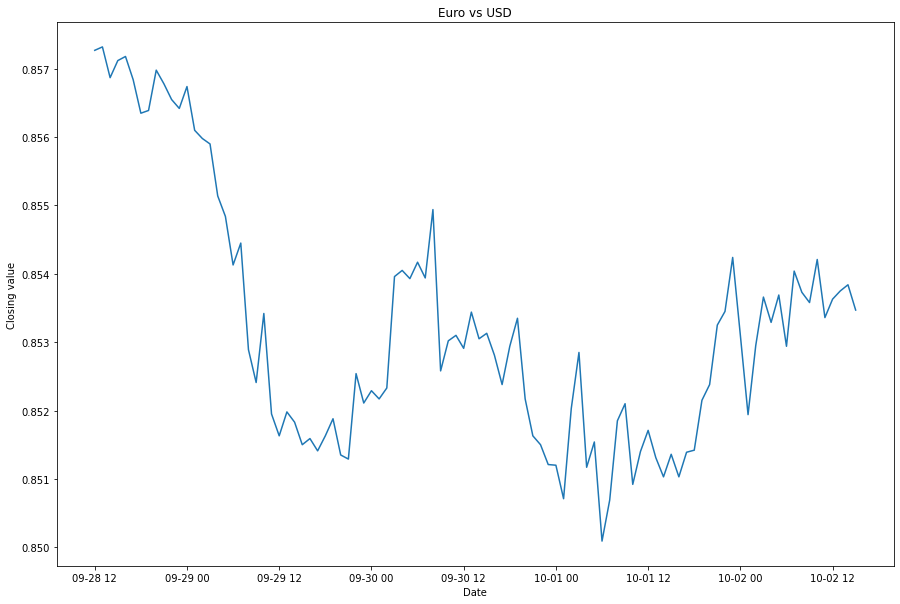

In [7]:
plt.figure(figsize = (15,10))
plt.plot(close_data)
plt.xlabel('Date')
plt.ylabel('Closing value')
plt.title ('Euro vs USD')
plt.show()


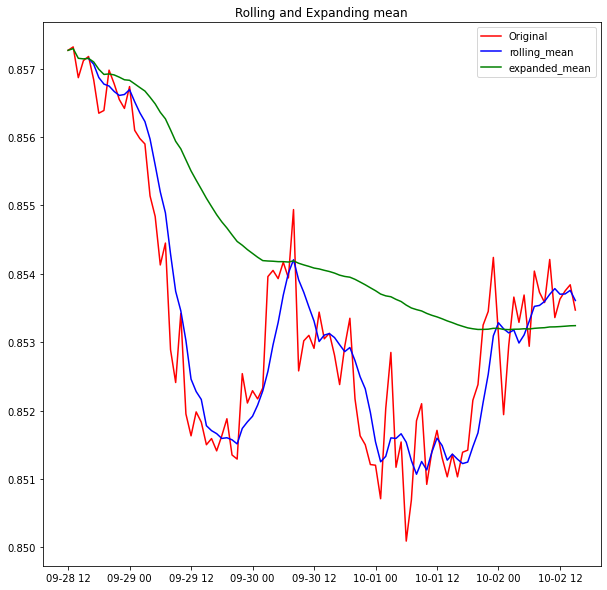

In [8]:
rolling_mean = close_data.rolling(window = 5).mean()
rolling_std = close_data.rolling(window = 5).std()
expanded_mean = close_data.expanding().mean()
plt.figure(figsize = (10,10))
plt.plot(close_data, color = 'red', label = 'Original')
plt.plot(rolling_mean, color = 'blue', label = 'rolling_mean')
# plt.plot(rolling_std, color = 'yellow', label = 'rolling_std')
plt.plot(expanded_mean, color = 'green', label = 'expanded_mean')
plt.title('Rolling and Expanding mean')
plt.legend()
plt.show()

#### Statistical test to check if data is stationary

In [9]:
dicker_fuller_results = adfuller(x = close_data,
                                 autolag = 'AIC')

print('Test statistics: ', dicker_fuller_results[0])
print('p-value: ', dicker_fuller_results[1])
print('Number of lags used: ', dicker_fuller_results[2])
print('Number of observations used: ', dicker_fuller_results[3])
for keys, values in dicker_fuller_results[4].items():
  print('critical value {}: {}'.format(keys, values))

Test statistics:  -2.4059664470858584
p-value:  0.14005949965311693
Number of lags used:  1
Number of observations used:  98
critical value 1%: -3.4989097606014496
critical value 5%: -2.891516256916761
critical value 10%: -2.5827604414827157


In [10]:
def transformed_data_results_view(data, window):
  # calculation of moving averages
  rolling_mean = data.rolling(window = window).mean()
  rolling_std = data.rolling(window = window).std()
  expanded_mean = data.expanding().mean()
  
  # plots
  plt.figure(figsize = (10,10))
  plt.plot(rolling_mean, color = 'blue', label = 'Rolling mean')
  plt.plot(expanded_mean, color = 'green', label = 'Expanding mean')
  plt.title('Pltos of rolling and expanding values')
  plt.legend()
  plt.show()

  # results of dickey-fuller test
  dicker_fuller_results = adfuller(x = data,
                                 autolag = 'AIC')

  print('Test statistics: ', dicker_fuller_results[0])
  print('p-value: ', dicker_fuller_results[1])
  print('Number of lags used: ', dicker_fuller_results[2])
  print('Number of observations used: ', dicker_fuller_results[3])
  for keys, values in dicker_fuller_results[4].items():
    print('critical value {}: {}'.format(keys, values))

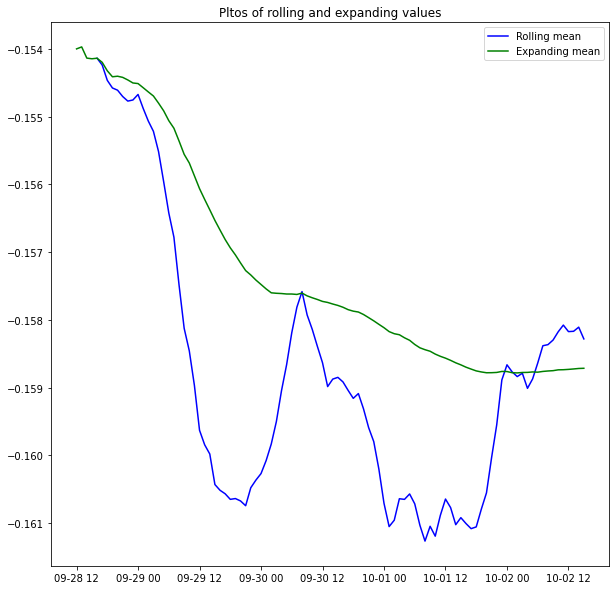

Test statistics:  -2.404654864921953
p-value:  0.14042691542358704
Number of lags used:  1
Number of observations used:  98
critical value 1%: -3.4989097606014496
critical value 5%: -2.891516256916761
critical value 10%: -2.5827604414827157


In [11]:
log_transformation = np.log(close_data)
transformed_data_results_view(data = log_transformation,
                              window = 5)

#### Split training and testing data

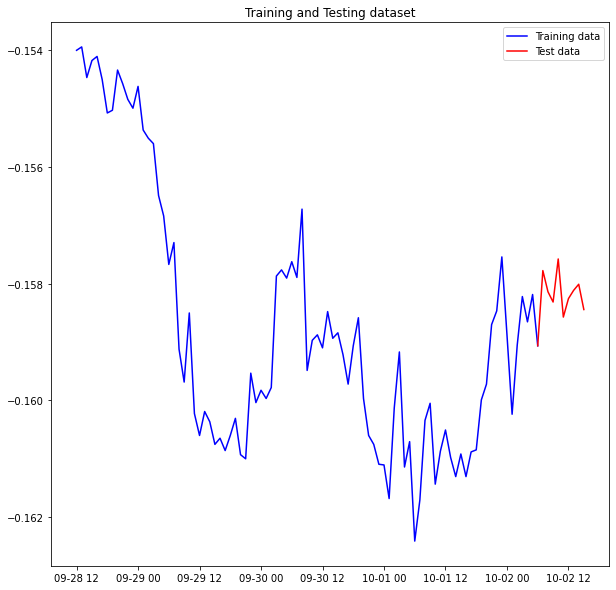

In [12]:
train_data  = log_transformation[:int(len(log_transformation)*0.9)+1]
test_data = log_transformation[int(len(log_transformation)*0.9):]
plt.figure(figsize = (10,10))
# plt.plot(log_transformation, color = 'black')
plt.plot(train_data, color = 'blue')
plt.plot(test_data, color = 'red' )
plt.legend(['Training data', 'Test data'])
plt.title('Training and Testing dataset')
plt.show()

#### Auto-arima model building

In [13]:
model_auto_arima = auto_arima(y = train_data,
                              start_p = 0,
                              start_q = 0,
                              test = 'adf',
                              max_p = 5,
                              max_q = 5,
                              d = None,
                              seasonal = True,
                              start_P = 0,
                              D = 0,
                              trace = True,
                              error_action = 'ignore',
                              suppress_warnings = True,
                              stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1022.738, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1024.496, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1025.794, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1024.295, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1024.187, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1024.284, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1019.298, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1027.044, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1025.374, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1025.433, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1025.873, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.245 seconds


In [17]:
model_auto_arima_results = model_auto_arima.get_params()
order_arima = model_auto_arima_results['order']
order_arima

(0, 1, 1)

In [18]:
arima_model = ARIMA(endog = train_data,
                    order = order_arima)
fitted_model = arima_model.fit(disp = -1)
fitted_model.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   90
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 515.952
Method:                       css-mle   S.D. of innovations              0.001
Date:                Mon, 05 Oct 2020   AIC                          -1025.905
Time:                        13:04:33   BIC                          -1018.405
Sample:                    09-28-2020   HQIC                         -1022.881
                         - 10-02-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.423e-05   6.06e-05     -0.896      0.370      -0.000    6.44e-05
ma.L1.D.y     -0.2696      0.107     -2.530      0.011      -0.478      -0.061
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            3.7094           +0.0000j            3.7094            0.0000
-----------------------------------------------------------------------------
"""

#### Forecasting for test dataset

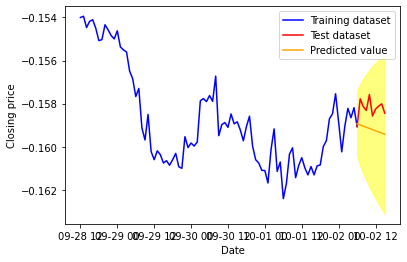

In [20]:
fc, se, conf = fitted_model.forecast(steps = len(test_data),
                                     alpha = 0.05)
fc_series = pd.Series(data = fc,
                      index = test_data.index)
lower_series = pd.Series(conf[:,0],
                         index = test_data.index)
upper_series = pd.Series(conf[:,1],
                         index = test_data.index)
plt.plot(train_data,
         color = 'blue',
         label = 'Training dataset')
plt.plot(test_data,
         color = 'red',
         label = 'Test dataset')
plt.plot(fc_series,
         color = 'orange',
         label = 'Predicted value')
plt.fill_between(x = lower_series.index,
                 y1 = lower_series,
                 y2 = upper_series,
                 color = 'yellow',
                 alpha = 0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Closing price')
plt.show()

### Function for ARIMA model prediction

In [26]:
def arima_model_result(symbol, resp, column = 'close'):
  # getting the data
  prices = [bar[column] for bar in resp]
  dates = [datetime.strptime(bar['timestamp'][:19], '%Y-%m-%dT%H:%M:%S') for bar in resp]
  close_data = pd.Series(prices, index=dates)
  close_data.plot()
  plt.close()
  close_data.index = pd.DatetimeIndex(data = close_data.index)

  # Dickey fuller test
  dicker_fuller_results = adfuller(x = close_data,
                                 autolag = 'AIC')
  print('Dickey-Fuller test for Raw data')
  print('Test statistics: ', dicker_fuller_results[0])
  print('p-value: ', dicker_fuller_results[1])
  print('Number of lags used: ', dicker_fuller_results[2])
  print('Number of observations used: ', dicker_fuller_results[3])
  for keys, values in dicker_fuller_results[4].items():
    print('critical value {}: {}'.format(keys, values))

  def transformed_data_results_view(data, window):
    # results of dickey-fuller test
    dicker_fuller_results = adfuller(x = data,
                                  autolag = 'AIC')

    print('Test statistics: ', dicker_fuller_results[0])
    print('p-value: ', dicker_fuller_results[1])
    print('Number of lags used: ', dicker_fuller_results[2])
    print('Number of observations used: ', dicker_fuller_results[3])
    for keys, values in dicker_fuller_results[4].items():
      print('critical value {}: {}'.format(keys, values))

  # log transformation on the data
  log_transformation = np.log(close_data)
  transformed_data_results_view(data = log_transformation,
                                window = 5)
  
  # split training and testing data
  train_data  = log_transformation[:int(len(log_transformation)*0.9)]
  test_data = log_transformation[int(len(log_transformation)*0.9):] 

  # auto arima model
  model_auto_arima = auto_arima(y = train_data,
                                start_p = 0,
                                start_q = 0,
                                test = 'adf',
                                max_p = 5,
                                max_q = 5,
                                d = None,
                                seasonal = True,
                                start_P = 0,
                                D = 0,
                                trace = True,
                                error_action = 'ignore',
                                suppress_warnings = True,
                                stepwise = True)
  
  model_auto_arima_results = model_auto_arima.get_params()
  order_arima = model_auto_arima_results['order']

  arima_model = ARIMA(endog = train_data,
                    order = order_arima)
  fitted_model = arima_model.fit(disp = -1)

  # forecasting the test data result
  fc, se, conf = fitted_model.forecast(steps = len(test_data),
                                     alpha = 0.05)
  
  fc_series = pd.Series(data = fc,
                      index = test_data.index)
  lower_series = pd.Series(conf[:,0],
                          index = test_data.index)
  upper_series = pd.Series(conf[:,1],
                          index = test_data.index)
  plt.figure(figsize = (10, 10))
  plt.plot(train_data,
          color = 'blue',
          label = 'Training dataset')
  plt.plot(test_data,
          color = 'red',
          label = 'Test dataset')
  plt.plot(fc_series,
          color = 'black',
          label = 'Predicted value')
  plt.fill_between(x = lower_series.index,
                  y1 = lower_series,
                  y2 = upper_series,
                  color = 'yellow',
                  alpha = 0.5)
  plt.legend()
  plt.xlabel('Date')
  plt.ylabel('Closing price')
  plt.show()





Dickey-Fuller test for Raw data
Test statistics:  -3.107321834824616
p-value:  0.02601606359613695
Number of lags used:  0
Number of observations used:  1439
critical value 1%: -3.4349024693573584
critical value 5%: -2.8635506057382325
critical value 10%: -2.5678404322793846
Test statistics:  -3.0735633763647487
p-value:  0.028572489332231825
Number of lags used:  0
Number of observations used:  1439
critical value 1%: -3.4349024693573584
critical value 5%: -2.8635506057382325
critical value 10%: -2.5678404322793846
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14393.695, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14391.725, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14391.723, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14394.799, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14389.689, Time=0.49 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.646 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


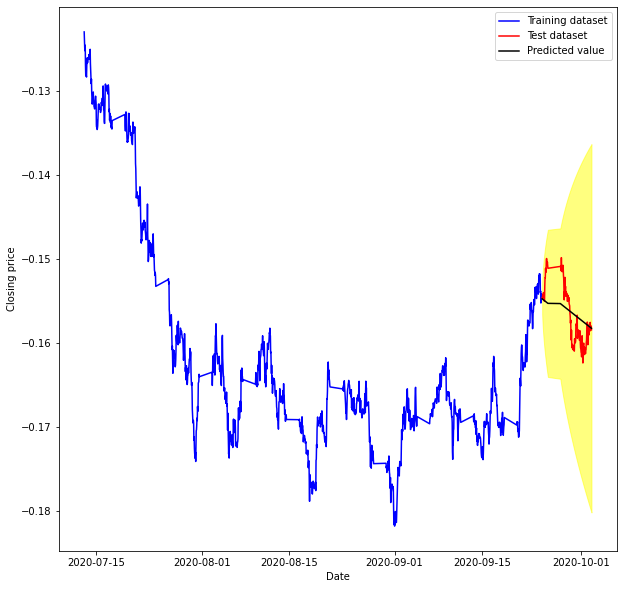

In [27]:
symbol = '^USDEUR'  #@param {type: "string"}

resp = od.history(symbol, 'minutes', interval=60, maxRecords=1440)['results']

arima_model_result(symbol, resp)
